<div style="text-align: center; font-weight: bold; font-size: 200%"> Modèle épidimiologique - covid-19</div>                                                        
<br />      
<div style="text-align: center; font-size: 150%">Projet MAP 568 - Ecole polytechnique</div><br />  
<div style="text-align: center; font-size: 120%">Calot Paul et Nagaev Sacha</div><br />  


# Préalable - installation des modules

```shell
conda create -n map568 python=3.9
```
Puis :
```shell
conda activate
```
Puis : 
```shell
conda install jupyter matplotlib numpy scipy bokeh
conda install -c auto prettyprint 
```

# Projet
Le modèle est définit dans [model](model.py#SEIR). De nombreuses variables et fonctions utilisées dans la suite sont définies dans [utils](utils.py). Nous attirerons l'attention au moment opportun sur les différences fonctions.

In [1]:
# my modules imports
    # Model
from model import SEIR
from model import f

    # utils
from utils import init_date, delta_time
from utils import draw_input_params, nb_inputs
from utils import extract_int_value, get_max_load_intensive_care
from utils import idx_to_keys, key_to_idx, input_params, ykeys, box_colors, plotting_names
from utils import Monte_Carlo_sampling, lhs

    # plotting
from utils_plotting import plot_hist, plot_morris, plot_sobol, plot_sobol_time

# other imports
from pprint import pprint
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
# bokeh plotting
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.layouts import row, column
from bokeh.models import PrintfTickFormatter
from bokeh.models import CustomJS, DateRangeSlider
from bokeh.models import Legend, ColumnDataSource, Label, LabelSet, Range1d
from bokeh.palettes import magma, viridis
output_notebook(hide_banner=True)

from ipywidgets import interact, IntSlider, Dropdown, FloatSlider

In [2]:
debug = True
seed = 1111

## Définition du Modèle

La classe *SEIR* importée du module [model](model.py) est utilisée pour créer le modèle épidémiologique à partir d'un tirage aléatoire du vecteur d'entrée $\vec{X}$ grâce à la fonction [draw_input_params](utils.py) qui prend en argument le *seed* et est définit dans [utils](utils.py), envoyé à la fonction *numpy.random.seed* par défaut :
```python
seed = None
np.random.seed(seed)
```

Dans la cellule suivante, on initialise un modèle, puis on le *print* en utilisant une [fonction](model.py) définit à l'intérieur de la classe *SEIR* avant d'effectuer un [pas "manuel"](model.py). Nous verrons que pour ce qui suit, nous utilisons exclusivement la fonction *odeint* du module *scipy.integrate* pour réaliser l'intégration du modèle.

Pour simplier également, plusieurs dictionnaires sont utilisés tout au long du *notebook* : 
```python

idx_to_keys = {
    0 : 'pa',
    1 : 'pIH',
    2 : 'pIU',
    3 : 'pHD',
    4 : 'pHU',
    5 : 'pUD',
    6 : 'NI',
    7 : 'NH',
    8 : 'NU',
    9 : 'R0',
    10 : 'mu',
    11 : 'N',
    12 : 't0',
    13 : 'Im0',
    14 : 'lambda1'
}

key_to_idx = {v : k for k, v in idx_to_keys.items()}

# bounds
input_params = {
    'pa': [0.4,0.9],
    'pIH' : [0.05, 0.2],
    'pIU' : [0.01, 0.04],
    'pHD' : [0.1, 0.2],
    'pHU' : [0.1,0.2],
    'pUD' : [0.2, 0.4],
    'NI' : [8.0, 12.0],
    'NH' : [15.0,25.0],
    'NU' : [10., 20.],
    'R0' : [2.9, 3.4],
    'mu' : [0.01, 0.08],
    'N' : [4*7+3, 7*7+3],
    't0' : [0, 4*7+3],
    'Im0' : [1., 100.],
    'lambda1' : [1e-4, 1e-3]
}
```

In [3]:
if(debug):
    x = draw_input_params(seed)
    model = SEIR(x)
    model.prettyprint()
    model.step(dt = 1.0) # dt in days 
    model.prettyprint()

============== SEIR MODEL ==============
----------- input parameters -----------
OrderedDict([('pa', 0.44777459960438104),
             ('pIH', 0.18875055527924495),
             ('pIU', 0.020307202696216567),
             ('pHD', 0.13104769418698442),
             ('pHU', 0.10020098399490976),
             ('pUD', 0.2471189448783151),
             ('NI', 8.951166880633519),
             ('NH', 22.359158732407092),
             ('NU', 14.954680759619642),
             ('R0', 3.2922126744045577),
             ('mu', 0.018855441784553242),
             ('N', 49),
             ('t0', 10),
             ('Im0', 47.1459765189812),
             ('lambda1', 0.0003134189119522501)])
---------------- Rates -----------------
OrderedDict([('gIR', 0.09881985306407182),
             ('gIH', 0.011644610401521123),
             ('gIU', 0.0012528146653254559),
             ('gHD', 0.005861029735302406),
             ('gHU', 0.004481429073164532),
             ('gHR', 0.03438194303365658),
            

Les fonctions suivantes permettent de réaliser, à partir d'un vecteur d'entrée $\vec{X}$ la simulation d'un modèle sur une période de temps donné. Pour des raisons pratiques, nous avons fini par utiliser un pas de temps toujours égal à un jour. La fonction *odeint* qui permet d'intégrer le système est en outre particulièrement précise avec ce pas de temps : aucune différence n'a été constater avec un pas de $0.1$ jour quand les premiers tests ont été effectués.

```python

def f(input_params, tend = datetime(year = 2020, month = 5, day = 11), verbose = False):    
    model = SEIR(input_params)
    
    if(verbose):
        model.prettyprint()
        
    fcn = model.get_fcn()
    y_ini = model.get_state()

    # in number of days
    tini = int(input_params[key_to_idx['t0']])
    init_date_simu = init_date+tini*timedelta(days = 1)
    
    t_simu = np.arange(tini, tini+(tend-init_date_simu).days+1)
    
    rtol, atol = 1e-3, 1e-6 # default values
    solution = odeint(func = fcn, t = t_simu, y0 = y_ini) 
    
    # we will make so that simulations always start from the same initialization time
    sol = fill_missing_values(solution, number_missing = tini, filling_value = 'first')
    return sol

```

## Q1) Afficage de la solution

Nous définissons ici une fonction permettant de réaliser l'affichage d'une solution via le packet *bokeh*. On utilise la fonction [get_max_load_intensive_care](utils.py) qui retourne la valeur du maximum de *U*, où le nombre de personnes en soin intensif, ainsi que le temps auquel cette valeur est atteinte. 

Nous faisons également appel à [box_colors](utils.py) et [plotting_names](utils.py) qui définissent les couleurs et noms d'affichage des différentes boîtes.

```python
plotting_names = {
    'S' : 'Susceptible (S)',
    'Im' : 'Infec. not Detec. (I-)',
    'Ip' : 'Infec. Detec. (I+)',
    'Rm' : 'Recov. not Detec. (R-)',
    'RI' : 'Recov. Detec. (R+)',
    'H' : 'Hospital (H)',
    'U' : 'Intensive care (U)',
    'RH' : 'Recov. Hosp. (R+H)',
    'D' : 'Dead (D)',
    'DR' : 'Detected (DR)'
}
box_colors = {
    'S' : 'goldenrod',
    'Im' : 'purple',
    'Ip' : 'orange',
    'Rm' : 'olive',
    'RI' : 'olivedrab',
    'H' : 'lightblue',
    'U' : 'pink',
    'RH' : 'darkolivegreen',
    'D' : 'red',
    'DR' : 'blue'
}
```

In [4]:
def plot_solution(seed = None, do_manually = False, verbose = False):
    x = draw_input_params(seed)
    tini = x[key_to_idx['t0']]
    
    sol = f(x)
    
    times = [init_date+k*delta_time for k in range(sol.shape[0])]
    
    sum_all = sol[:,:-1].sum(axis=1)
    max_time, max_U = get_max_load_intensive_care(sol)
    
    print('Max intensive care load at days {} with {} patients.'.format(times[max_time], max_U))
    
    fig_sol = figure(plot_height=450, plot_width=900, title="Solution", x_axis_type='datetime')
    
    legend_it = []

    for idx, (key, name) in enumerate(plotting_names.items()):
        c = fig_sol.x(times, sol[:,idx], line_width=1, color = box_colors[key], alpha=0.9, muted_color=box_colors[key], muted_alpha=0.01) # legend_label="Speed")
        if(do_manually):
            c_ = fig_sol.line(times_, sol_bis[:,idx], line_width=1, color = box_colors[key], alpha=0.9, muted_color=box_colors[key], muted_alpha=0.01) # legend_label="Speed")
            legend_it.append((name, [c,c_]))
        else:
            legend_it.append((name, [c]))
    c = fig_sol.x(times,sum_all, line_width=1, color = 'black', alpha=0.9, muted_color="black", muted_alpha=0.01) # legend_label="Speed")
    legend_it.append(('Sum', [c]))

    legend = Legend(items=legend_it)
    legend.click_policy="mute"
    fig_sol.add_layout(legend, 'right')

    show(fig_sol, notebook_handle=True)
    

In [5]:
plot_solution(seed = seed, do_manually = False)

Max intensive care load at days 2020-04-21 00:00:00 with 305527 patients.


# Q2) 
Pour cette deuxième question, on fait appel à [draw_input_params](utils.py) avec à chaque fois ```seed = None```.

La fonction ci-dessous *Monte_Carlo_Umax* permet de réaliser le tirage de $N$ échantillons et d'obtenir les valeurs de $U_{max}$ et $T(U_{max})$ résultants via [get_max_load_intensive_care](utils.py). 

In [6]:

def Monte_Carlo_Umax(N = 100):
    list_U = []
    list_times = []
    
    for k in range(N): 
        x = draw_input_params()    
        sol = f(x, tend = datetime(year = 2020, month = 9, day = 1))
        
        max_time, max_U = get_max_load_intensive_care(sol)
        
        list_U.append(max_U)
        list_times.append(max_time)
    
    return np.array(list_U), np.array(list_times)

In [7]:
N=500 # number of draws
list_U, list_times = Monte_Carlo_Umax(N=N)

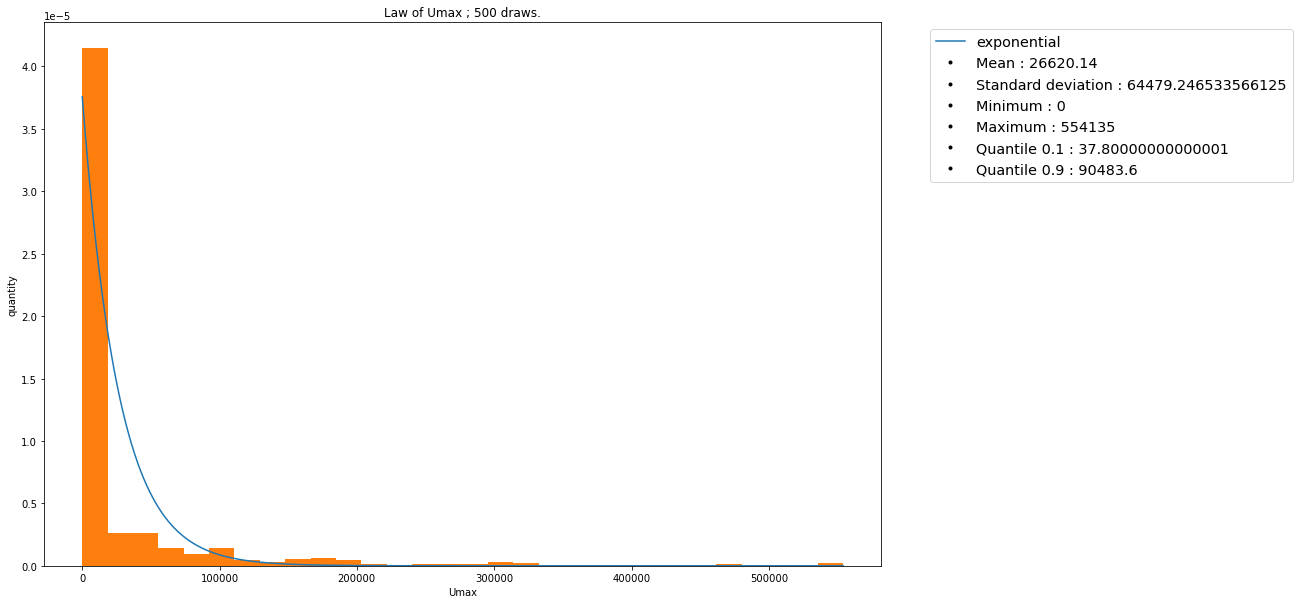

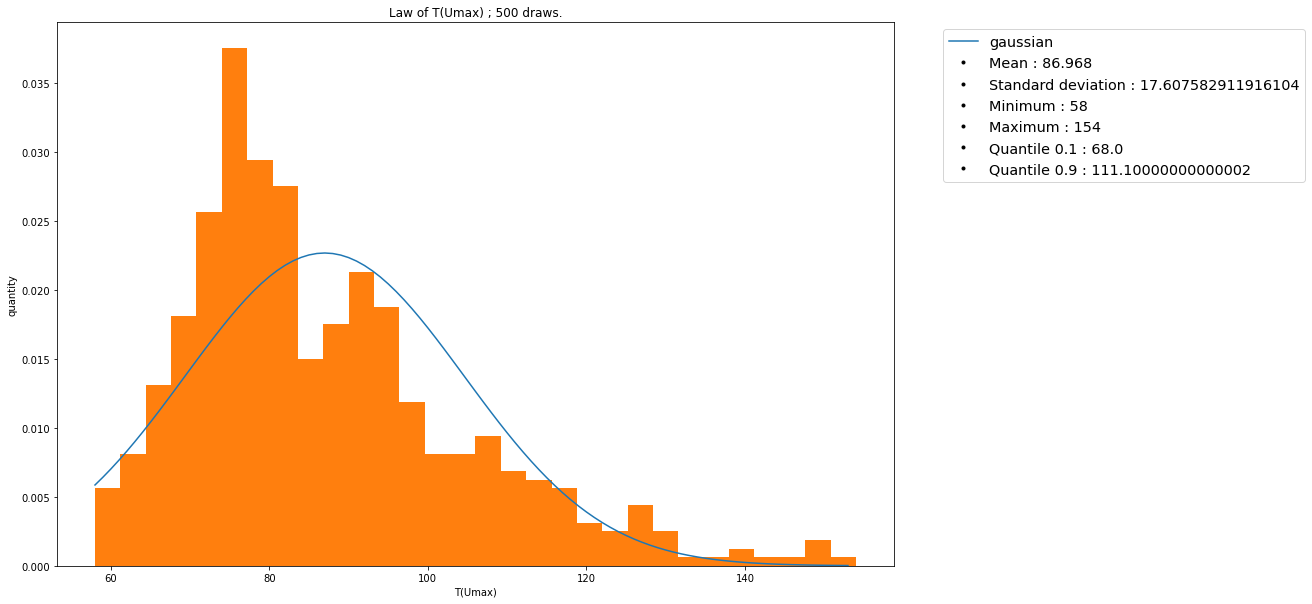

In [8]:
from scipy.stats import chi2, norm, poisson, expon
bins = 30

# Defintion of a given number of law if we want to try to find one that suits the data
gaussian_pdf = lambda x, mean, std : norm.pdf(x=x, loc = mean, scale = std)
exponential_pdf = lambda x, mean, std : expon.pdf(x=x, loc=0, scale=mean) # scale = 1/lambda = Esp(U)
chi2_k1_pdf = lambda x, mean, std : chi2.pdf(x=x, df=1, loc=0, scale=mean) # df : degrees of freedom 
poisson_pmf = lambda x, mean, std : poisson.pmf(x, mu = mean, loc=0)

plot_hist(list_U, bins = bins, name = 'Umax', law = exponential_pdf, name_law = 'exponential', savefig = 'law_Umax')
plot_hist(list_times, bins = bins, name = 'T(Umax)', law = gaussian_pdf, name_law = 'gaussian', savefig = 'law_T(Umax)')

## Q3) Méthode de Morris 

### Première méthode

Dans un premier temps nous avons essayé de coder nous-même la méthode de Morris et de Sobol le plus simplement possible : différences finies pour calculer le gradient par exemple.

Nous avons choisi de vous présenter d'abord ces résultats. Vous pouvez vous référez à [sensitivy_analysis_by_hands](sensitivy_analysis_by_hands.py) pour les fonctions réalisées que nous utilisons ici.

In [9]:
from sensitivy_analysis_by_hands import  Morris

In [10]:
fn = lambda sol : get_max_load_intensive_care(sol)
mu_arr, sigma_arr = Morris(fn = fn, h = 2, R = 20, delta = 1e-6, method = 'lhs')

In [11]:
print('{:-^100}'.format(' Umax '))
plot_morris(mu_arr[1], sigma_arr[1], names = 'default')

----------------------------------------------- Umax -----------------------------------------------


In [12]:
print('{:-^100}'.format(' T(Umax) '))
plot_morris(mu_arr[0], sigma_arr[0], names = 'default')

--------------------------------------------- T(Umax) ----------------------------------------------


En pratique, en affichant les différences finies, il apparait que certaines explosent. Après plusieurs tentatives vaines de corriger ce problème, nous avons chercher pour des solutions alternatives. Nous pensons que cela est dû à la relative simplicité de notre implémentation.

#### Analyse de Morris - via *SALib*

Au vu des résultats que nous obtenions, principalement, nous avons cherché des solutions alternatives. Nous utisons ici le package *SALib* de *Python*.

In [13]:
# Morris 
from SALib.sample import morris as morris_
from SALib.analyze import morris
from utils import lhs

# Define the model inputs
names = list(idx_to_keys.values())
bounds = list(input_params.values())

# Definition of the problem
problem = {
    'num_vars': 15,
    'names': names,
    'bounds': bounds
}

# SALib requires arrays of type float.
fn = lambda x : get_max_load_intensive_care(f(x)) # T(Umax)

def eval_fn(X):
    TU,U = [], []
    for x in X:
        tu, u = fn(x)
        TU.append(tu)
        U.append(u)
    return np.array(TU, dtype = float), np.array(U, dtype = float)

In [14]:
Xm = morris_.sample(problem, 100, num_levels=4) # lhs(1600) 
YmT, Ym = eval_fn(Xm)

In [15]:
# Morris analysis on T(Umax)
MT = morris.analyze(problem, Xm.astype(float), YmT.astype(float), conf_level=0.95, \
                    print_to_console=False, num_levels=4)


In [16]:
# Morris analysis on Umax
M = morris.analyze(problem, Xm.astype(float), Ym.astype(float), conf_level=0.95, \
                    print_to_console=False, num_levels=4)

In [17]:
print('{:-^100}'.format(' Umax '))
plot_morris(M['mu_star'], M['sigma'], names = 'default')

----------------------------------------------- Umax -----------------------------------------------


In [18]:
print('{:-^100}'.format(' T(Umax) '))
plot_morris(MT['mu_star'],MT['sigma'],  names = 'default')

--------------------------------------------- T(Umax) ----------------------------------------------


Les résultats que nous obtenons ici sont beaucoup plus satisfaisants. Plus un paramètre est à droite sur l'axe des abscisses, plus il a un effet linéaire important. Plus il est haut sur l'axe des ordonnées, plus il a également un effet non linéaire (ou en interaction avec d'autres paramètres) sur la sortie. On constate donc qu'en moyenne le système est hautement non linéaire et complexe : l'impact d'un paramètre peut difficilement se concevoir sans son interaction avec d'autres paramètres même s'il possède un impact linéaire assez important également. Au regard des valeurs mises en jeu pour $U_{max}$, on voit que les écarts types sont en moyenne un ordre de grandeur supérieur aux moyennes témoignant de l'importance relative des effets non linéaires.

En outre, on retrouve les valeurs :  $p_a$, $N_I$, $R_0$, $\mu$, $t_0$, $I^-_0$ comme étant parmis celles ayant le plus d'impact. Ce qui justifie le choix de se concentrer sur celles-là dans ce qui suit.

## Q4) Analyse de sensiblité de Sobol
### Première méthode - à la main
Ici encore, nous donnons les résultats obtenus par les algorithmes implémentés que nous avons implémentés.

Vous pouvez vous référez à [sensitivy_analysis_by_hands](sensitivy_analysis_by_hands.py) pour la fonction Sobol que nous utilisons ici.


In [19]:
from sensitivy_analysis_by_hands import Sobol

# indexes that we are interested into
names = ['pa','NI','R0','mu','t0','Im0']
idxes = [key_to_idx[n] for n in names]

In [20]:
S, St = Sobol(fn = get_max_load_intensive_care, R = 200, method = 'MC')

In [21]:
print('{:-^100}'.format(' Umax '))
# plot_sobol(S[:,0],St[:,0])
plot_sobol(S[idxes,0],St[idxes,0], names = names)

----------------------------------------------- Umax -----------------------------------------------


In [22]:
print('{:-^100}'.format(' T(Umax) '))
# plot_sobol(S[:,1],St[:,1])
plot_sobol(S[idxes,1],St[idxes,1], names = names)

--------------------------------------------- T(Umax) ----------------------------------------------


Une première remarque consiste à observer qu'on a des indices totaux inférieurs à des indices de premiers ordre pour certains paramètres. Cela est dû à l'estimation réalisée ici qui comprend des erreurs. On observe ensuite ici que la variable $t_0$ à un impact fort sur $U_{max}$ en lien avec d'autres variables, tandis que les autres ont plutôt un impact propre fort.  De plus, $T(U_{max})$ est impact par les paramètres précédemment choisis de façon assez importantes sauf pour $I^-_0$. Contrairement à $U_{max}$, les impacts ici sont en lien avec d'autres variables pour tous. On peut s'étonner de ces résultats au regarde de l'analyse de Morris pour laquelle on voyait que les effets non linéaires était important pour $U_{max}$. 

### Analyse de Sobol - via *SALib*
Les quelques incohérences constatées nous ont également poussé à réaliser l'analyse de Morris pour ce système.

L'analyse de Sobol se ramène ici à définir le problème et calculer les sorties du code à partir des échantillons choisis pour envoyer ensuite à *sobol.analyse* qui réalise le travail.

In [23]:
# Same as for Morris analysis

# Define the model inputs
names = list(idx_to_keys.values())
bounds = list(input_params.values())

# Definition of the problem
problem = {
    'num_vars': 15,
    'names': names,
    'bounds': bounds
}

# SALib requires arrays of type float.
fn = lambda x: get_max_load_intensive_care(f(x)) # T(Umax)

def eval_fn(X):
    TU, U = [], []
    for x in X:
        tu, u = fn(x)
        TU.append(tu)
        U.append(u)
    return np.array(TU, dtype = float), np.array(U, dtype = float)


In [24]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami

In [25]:
# Generate samples
param_values = saltelli.sample(problem, 100)
# Run model (example)
YT, Y = eval_fn(param_values)

In [26]:
# Perform analysis
Si_T = sobol.analyze(problem, YT)
Si = sobol.analyze(problem, Y)

In [28]:
# indexes that we are interested into
names = ['pa','NI','R0','mu','t0','Im0']
idxes = [key_to_idx[n] for n in names]

print('{:-^100}'.format(' Umax '))
plot_sobol(Si['S1'][idxes],Si['ST'][idxes], names = names)
print('{:-^100}'.format(' T(Umax) '))
plot_sobol(Si_T['S1'][idxes],Si_T['ST'][idxes],names=names)

----------------------------------------------- Umax -----------------------------------------------


--------------------------------------------- T(Umax) ----------------------------------------------


Contrairement à précédemment et l'analyse via les algorithmes que nous avons codé, les résultats sont différents. En effet, sur $U_{max}$ les résultats sont en accord avec l'analyse de Morris : l'impact d'un paramètre doit être considéré dans sa relation aux aux paramètres. Pour $T(U_{max})$, c'est moins le cas. On voit d'ailleurs que pour ce dernier, le paramètre $\mu$ est particulièrement important.

## Q5) Analyse de Sobol pour $H$, $U$, $D$, $RH$ et en fonction du temps

In [29]:
def HUDRH(sol): # since we are using f inside the functions and that f returns solution that starts the same day each time, we can simply compare it this way
    # order : S, Im, Ip, Rm, RI, H, U, RH, D, DR
    return np.transpose(sol[:, [ykeys['H'],ykeys['U'],ykeys['D'],ykeys['RH']]]) # not taking the first value as the 0 causes problem to appear

In [30]:
sobol_manual = False # by default, not done with our algorithm.
if(sobol_manual):
    names = ['H','U','D','RH']
    idxes = [key_to_idx[n] for n in names]
    S, St = Sobol(fn = HUDRH, R = 200, method = 'MC')
    for idx, s in enumerate(['H','U','D','RH']):  
        print('{:-^100}'.format(' '+s+' '))
        plot_sobol_time(S[idxes,idx,:],St[idxes,idx,:], names = names)

### En utilisant *SALib* :

In [31]:
def eval_fn_HUDRH(X):
    H, U, D, RH = [],[],[],[]
    for x in X:
        h, u, d, rh = HUDRH(f(x))
        H.append(h)
        U.append(u)
        D.append(d)
        RH.append(rh)
    return np.array(H, dtype = float), np.array(U, dtype = float), np.array(D, dtype = float), np.array(RH, dtype = float)

In [32]:
# Generate samples
param_values = saltelli.sample(problem, 100)
# Run model (example)
H,U,D,RH = eval_fn_HUDRH(param_values) # size [nb_input, nb times]

In [33]:
# Perform analysis
Si_H = np.array([list(map(sobol.analyze(problem, H[:,k]).get, ['S1','ST'])) for k in range(H.shape[1])]) # shape : [nb_times, 2, nb_input_params = 15]
Si_U = np.array([list(map(sobol.analyze(problem, U[:,k]).get, ['S1','ST'])) for k in range(U.shape[1])])
Si_D = np.array([list(map(sobol.analyze(problem, D[:,k]).get, ['S1','ST'])) for k in range(D.shape[1])])
Si_RH = np.array([list(map(sobol.analyze(problem, RH[:,k]).get, ['S1','ST'])) for k in range(RH.shape[1])])

/home/paul/anaconda3/envs/map568/lib/python3.9/site-packages/SALib/analyze/sobol.py:93: RuntimeWarning: invalid value encountered in true_divide
  Y = (Y - Y.mean()) / Y.std()


In [34]:
sobol_analysis_time = {
    'H':Si_H,
    'U':Si_U,
    'D':Si_D,
    'RH':Si_RH
}

In [37]:
names = ['pa','NI','R0','mu','t0','Im0']
idxes = [key_to_idx[n] for n in names]
for idx, s in enumerate(['H','U','D','RH']):  
    print('{:-^100}'.format(' '+s+' '))
    values = sobol_analysis_time[s]
    plot_sobol_time(np.transpose(values[:,0,idxes]),np.transpose(values[:,1,idxes]), names = names)

------------------------------------------------ H -------------------------------------------------


------------------------------------------------ U -------------------------------------------------


------------------------------------------------ D -------------------------------------------------


------------------------------------------------ RH ------------------------------------------------


On constate que pour les grandeurs d'intérêt on a souvent $t_0$ qui est un paramètre très important, principalement au début de l'épidémie. L'impact de $t_0$ doit être considéré dans sa relation aux autres paramètres. En analysant finement ces graphes, on peut identifier les paramètres les plus importants et à quel moment de l'épidémie pour chaque grandeur d'intérêt.

## Q6) Affichage des données

In [38]:
import pandas as pd
import numpy as np
from pprint import pprint
from datetime import timedelta, date, datetime

In [39]:
path = 'data/donnees-hospitalieres-covid19-2021-03-01-19h03.csv'
path_dr = 'data/data_dr.csv'

Par défaut, on prend les données entre le 21/02/2020 et le 11/05/2020 en ajoutant des ```NaN``` là où c'est nécessaire (pour 

In [45]:
def convert_data(path, path_dr, start_date = None, end_date_f = None):
    # by default, the data spans 21/02/2020 to 11/05/2020
    # start_date and end_date_f allows to cut into it.
    
    # all
    df = pd.read_csv(path, sep = ';', header=0, parse_dates = ['jour'])
    df = df.loc[df['sexe']== 0]
    df = df.groupby(by = ['jour']).sum()
    result = np.where(df.index=='2020-05-11')[0]
    assert(len(result)==1)
    df=df[:result[0]+1]
    
    # DR
    df_dr = pd.read_csv(path_dr, sep = ',', header=0)
    result = df_dr[df_dr['date']=='11/05'].index.values[0]
    df_dr=df_dr[:result+1]
    dr = df_dr['nbre'].values
    dr[1:] -= dr[:-1]
    
    nb_to_add = len(dr) - len(df)
    a = np.empty((nb_to_add))
    a[:] = np.nan
    H = np.concatenate([a, df['hosp'].values])
    U = np.concatenate([a, df['rea'].values])
    D = np.concatenate([a, df['dc'].values])
    R = np.concatenate([a, df['rad'].values])

    min_start = datetime(year = 2020, month = 2, day = 21) # in the data
    end_lockdown =  datetime(year = 2020, month = 5, day = 11) 
    delta_time = timedelta(days = 1)
    
    list_of_times = [min_start+k*delta_time for k in range((end_lockdown-min_start+delta_time).days)]

    mon_dico = {
        'date' : list_of_times,
        'H' : H,
        'U' : U,
        'RH' : R,
        'D' : D,
        'DR' : dr
    }
    df = pd.DataFrame.from_dict(mon_dico)
    if(start_date != None):
        if(end_date_f != None):
            mask = (df['date'] >= start_date) & (df['date'] <= end_date_f)
        else:
            mask = df['date'] >= start_date

        df = df.loc[mask]
        #df = df[]
    return df

In [46]:
def plot_data(values, pred = None):
    p = figure(plot_height=450, plot_width=900, x_axis_type='datetime')
    p.x(values['date'], values['H'], color=box_colors['H'], alpha=1, size=10, legend_label = 'H',  muted_color=box_colors['H'], muted_alpha=0.01)
    p.x(values['date'], values['U'], color=box_colors['U'], alpha=1, size=10,legend_label = 'U', muted_color=box_colors['U'], muted_alpha=0.01)
    p.x(values['date'], values['D'], color=box_colors['D'], alpha=1, size=10,legend_label = 'D', muted_color=box_colors['D'], muted_alpha=0.01)
    p.x(values['date'], values['RH'], color=box_colors['RH'], alpha=1,size=10, legend_label = 'RH', muted_color=box_colors['RH'], muted_alpha=0.01)
    p.x(values['date'], values['DR'], color=box_colors['DR'], alpha=1, size=10,legend_label = 'DR', muted_color=box_colors['DR'], muted_alpha=0.01)
        
    if(pred != None):
        p.line(pred['date'], pred['H'], line_width=1,color=box_colors['H'], alpha=1)
        p.line(pred['date'], pred['U'], line_width=1,color=box_colors['U'], alpha=1)
        p.line(pred['date'], pred['D'], line_width=1,color=box_colors['D'], alpha=1)
        p.line(pred['date'], pred['RH'], line_width=1,color=box_colors['RH'], alpha=1)
        p.line(pred['date'], pred['DR'], line_width=1,color=box_colors['DR'], alpha=1)
        
    p.legend.location = "top_left"
    p.legend.click_policy = "mute"
    
    show(p)

In [47]:
ground_truth_full = convert_data(path, path_dr)

In [48]:
plot_data(ground_truth_full)

# Q7)

In [49]:
from scipy.optimize import minimize
from datetime import datetime

In [52]:
def fun(x, target, data_start, t_end, select = ['H','U','RH','D','DR'], verbose = False):
    from utils import init_date
    debug=False

    sol = f(x, tend = t_end)
    
    days_before_data = (data_start-init_date).days
    idxes = [ykeys[n] for n in select] 
    pred =  sol[days_before_data:,idxes] # all times but only select indexes
        
    return least_squared(pred, target)

def least_squared(pred, target):
    eps = 1e-10
    residuals = ((pred-target)/np.sqrt(pred+eps))**2
    return np.sum(np.where(residuals == residuals, residuals, 0))

On peut définir des contraintes pour la minimisation pour maintenir $t_0$, $N$ ou $I_0^-$ entiers. En pratique, on constate que cela fonctionne mieux sans contrainte. Pour l'utilisation des contraintes il faut donner *cons* à la fonction *launch_several_tests* définie après.

In [53]:
def contraints(x):
    #N = x[key_to_idx['N']]
    t0 = x[key_to_idx['t0']]

    return t0-int(t0) # np.array([N-int(N), t0 - int(t0)])

cons = {'type':'eq', 'fun': contraints}

#### Minimizing

In [54]:
first_lockdown = datetime(year = 2020, month = 3, day = 18) # date that we can use to get better results
end_fit = datetime(year = 2020, month = 3, day = 31) # 31/03
end_lockdown =  datetime(year = 2020, month = 5, day = 11) # end lockdown

data_to_fit = convert_data(path, path_dr, start_date = first_lockdown, end_date_f = end_fit)
plot_data(data_to_fit)

Nous allons lancer la minimisation sur plus tirage des paramètres d'entrée différents pour essayer d'avoir le 'meilleur'.

In [58]:
def launch_several_tests(target, launches = 10, constraints = None):
    from utils import input_params, lhs
    bounds = input_params.values()
    err_min = np.inf
    x_best = None
    X = lhs(launches)
    for x in X:
        fun_to_min = lambda x : fun(x, target = target, data_start = first_lockdown, t_end = end_fit)
        argmin = minimize(fun_to_min, x, bounds=bounds, constraints = constraints)
        err = argmin.fun
        if(err < err_min):
            x_best = argmin.x
            err_min = err
    return err_min, x_best

In [59]:
target = data_to_fit.values[:,1:] # values.values[:dt_day_max,1:] # not taking datetime
err_min, x_best = launch_several_tests(target, launches = 10)
print('Best input params : {} with quadratic error : {}'.format(x_best, err_min))

Best input params : [4.09906081e-01 5.28097735e-02 1.08912346e-02 2.00000000e-01
 1.00000000e-01 3.94786904e-01 9.64240409e+00 1.50000000e+01
 1.64267214e+01 3.21190308e+00 4.19447851e-02 4.84961054e+01
 8.73133865e+00 1.04532118e+01 1.00000000e-03] with quadratic error : 3874.4899205200536


In [60]:
sol = f(x_best)
pred_dict = {
    'date': [init_date+k*delta_time for k in range(sol.shape[0])],
    'H' : sol[:,ykeys['H']],
    'U' : sol[:,ykeys['U']],
    'RH' : sol[:,ykeys['RH']],
    'D' : sol[:,ykeys['D']],
    'DR' : sol[:,ykeys['DR']]
}

Avec seulement les données à fit :

In [61]:
plot_data(data_to_fit, pred_dict)

En comparant avec toutes les données :

In [62]:
plot_data(ground_truth_full, pred_dict)

On peut également s'assurer qu'on vérifie bien les contraintes.

In [63]:
for k, p in enumerate(x_best):
    param = input_params[idx_to_keys[k]]
    print('{} < {} < {}'.format(param[0],p,param[1]))

0.4 < 0.40990608101961373 < 0.9
0.05 < 0.05280977351597938 < 0.2
0.01 < 0.010891234636355216 < 0.04
0.1 < 0.2 < 0.2
0.1 < 0.1 < 0.2
0.2 < 0.3947869040381072 < 0.4
8.0 < 9.642404091961485 < 12.0
15.0 < 15.0 < 25.0
10.0 < 16.426721441336635 < 20.0
2.9 < 3.2119030751687068 < 3.4
0.01 < 0.04194478510999342 < 0.08
31 < 48.49610543744557 < 52
0 < 8.731338646409474 < 31
1.0 < 10.453211767190473 < 100.0
0.0001 < 0.001 < 0.001
